In [ ]:
# Calculating best spectral index

In [1]:
import os 
import numpy as np
import matplotlib as plt

In [ ]:
# calc NDSI, NDWI, NDVI

# already have NDSI

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/All_NDSI')
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/All_NDVI')
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/All_NDWI')

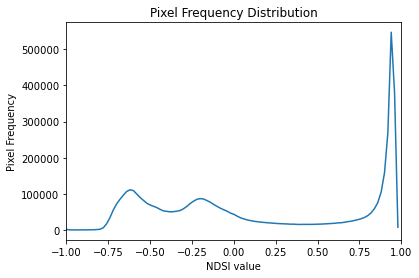

In [22]:
# plot pixel density distributions to find optimal thresholds
# a histogram is a graphical representation showing how frequently various color values occur in the image.

# https://datacarpentry.org/image-processing/05-creating-histograms/ 
"""
 * Generate a grayscale histogram for an image.
 *
 * Usage: python GrayscaleHistogram.py <fiilename>
"""
import sys
import numpy as np
import skimage.color
import skimage.io
from matplotlib import pyplot as plt
from imageio import imread


os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/All_NDSI')
image = imread('Alaska_NDSI.tif')


# plot as histogram
histogram, bin_edges = np.histogram(image, bins=100, range=(-1, 1)) # bins 256


# histogram 
plt.figure()
plt.title("Pixel Frequency Distribution")
plt.xlabel("NDSI value")
plt.ylabel("Pixel Frequency")
plt.xlim([-1.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

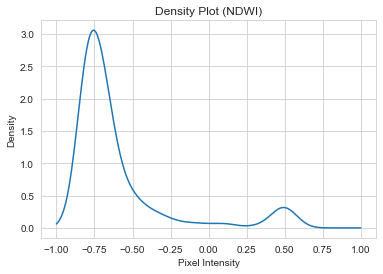

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/All_NDWI')

image = imread('Canada_NDWI.tif')

pixel = image[1]



#for pixel in image:
data = pixel #[2,3,3,4,2,1,5,6,4,3,3,3,6,4,5,4,3,2]
density = kde.gaussian_kde(data)

x = np.linspace(-1,1,400)
y=density(x)

plt.plot(x, y)
plt.title("Density Plot (NDWI)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.show()

In [197]:
# apply optimal thresholds for each index 
# minus the NDWI and NDVI from the NDSI to get the snow mask

import cv2
#import Image
from tifffile import imsave
from PIL import Image, ImageOps, ImageFilter


os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/France') 


NDSI = imread('France_NDSI.tif')
#NDSI = NDSI/255
NDWI = imread('France_NDWI.tif')
#NDWI = NDWI/255
NDVI = imread('France_NDVI.tif')


def to_mask(input_image, threshold):
    input_image[input_image <= threshold] = np.nan
    input_image[input_image > threshold] = 1
    return input_image
    
    
NDSI_mask = to_mask(NDSI, 0.35) # 0.35
NDWI_mask = to_mask(NDWI, 0.25) # 0.25
NDVI_mask = to_mask(NDVI, 0.20) # 0.20



NDWI_binary_mask = np.nan_to_num(NDWI_mask)
NDSI_binary_mask = np.nan_to_num(NDSI_mask)
NDVI_binary_mask = np.nan_to_num(NDVI_mask)



both = NDSI_binary_mask + NDWI_binary_mask  #+ NDVI_binary_mask #
snow_only = both.copy()
print("RRRR0 and 1", np.unique(snow_only, return_counts=True))
snow_only[snow_only == 2.] = 0

print("snow only", snow_only)
print("hi",snow_only[snow_only == 2.])


print("unique", np.unique(snow_only, return_counts=True))


#img = Image.fromarray(snow_only) #.astype('uint8')

#im = Image.fromarray((basemap_tiles[index] * 255).astype(np.uint8))

# save in SI snow mask folder
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/Snow_masks') 
outfile = "France_SI_snow_mask111111.tif"


out = imageio.imwrite(outfile, (snow_only * 255).astype('uint8')) 



read_im = imread(out)
img = Image.fromarray(read_im)

img.save(outfile)


RRRR0 and 1 (Array([0., 1., 2.], dtype=float32), array([5300189,  314410,   70159]))
snow only [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
hi []
unique (Array([0., 1.], dtype=float32), array([5370348,  314410]))


OSError: Cannot understand given URI: None.

In [165]:
# calc iou
# https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation

# IoU = true positive / (true positive + false positive + false negative)

from sklearn.metrics import confusion_matrix  
import numpy as np



os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/Snow_masks') 
# SI pic
y_pred = imread('France_SI_snow_mask.tif')

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/LABELS')
# ground truth
y_true = imread('FR_bbox1_5.png') #/ 255) 

y_true = y_true/255
#print("unique", np.unique(y_true))


def compute_iou(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)


#compute_iou(y_pred, y_true)


# conf matrix
y_pred = y_pred.flatten()
y_true = y_true.flatten()
confusion_matrix(y_true, y_pred, labels=[0, 1])


# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html 

# results:
# forested
# NZ miou: 0.9245122662473368
# CN miou: 0.5661474466421499
# france: 0.6621255835893318

#non-forested
# alaska: 0.7212450746880599
# argentina: 0.8189204859356305
# Norway: 0.8685089674657489



array([[5484154,   91941],
       [  38941,   69722]])

precision: 0.6416351471982183
recall 0.6812798846984158
F1_score 0.6608634848981119


Text(34.0, 0.5, 'real values')

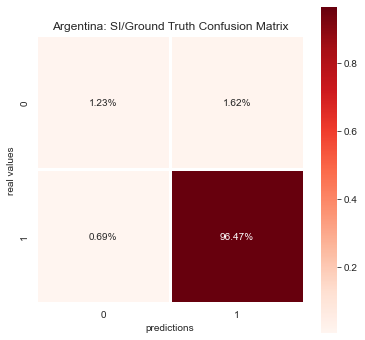

In [263]:
import seaborn as sns

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/Snow_masks') 
# SI pic
Y_pred = imread('France_SI_snow_mask.tif')

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/LABELS')
# ground truth
Y_val = imread('FR_bbox1_5.png') #/ 255) 

# Al_bbox1_2
#Arg_bbox3_2
#Nor_bbox1_18

#CN_bbox3_4
#FR_bbox1_5
#NZ_bbox1_8


Y_val = Y_val/255
#print("unique", np.unique(y_true))


FP = len(np.where(Y_pred - Y_val  == -1)[0])
FN = len(np.where(Y_pred - Y_val  == 1)[0])
TP = len(np.where(Y_pred + Y_val ==2)[0])
TN = len(np.where(Y_pred + Y_val == 0)[0])
cmat = [[TP, FN], [FP, TN]]


precision_score = TP / (FP + TP) 
print('precision:',precision_score)


recall_score = TP / (FN + TP) 
print("recall", recall_score)


F1_score = 2* precision_score * recall_score/ (precision_score + recall_score)
print("F1_score", F1_score)




plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.title("Argentina: SI/Ground Truth Confusion Matrix")
plt.xlabel("predictions")
plt.ylabel("real values")
#plt.show()

In [219]:
# for predicted from model:


         
         
from sklearn.metrics import confusion_matrix  
import numpy as np



os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/RESULTS/Fullset/Predicted_masks/Tiles_stitched')
# model predicted mask pic
y_pred = imread('NZ_predicted.png')
#print("unique", np.unique(y_pred))

y_pred = y_pred/255
print("unique", np.unique(y_pred))

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/RESULTS/Fullset/Predicted_masks/Tiles_stitched/Ground_truth')
# ground truth
y_true = imread('NZ_Ground_truth_stitched.png') #/ 255) 

y_true = y_true/255


# dont need to /255 because its already 0-1
#print("unique", np.unique(y_true))

from sklearn.metrics import f1_score
#print("unique", np.unique(y_true))

def compute_iou(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    #dice = K.mean((2. * intersection + 1)/(union + 1), axis=0)
    #f1 = f1_score(y_true, y_pred) # average='weighted')
    #intersection.astype('float32')
    #union.astype('float32')
    pooled_grads = K.mean(K.constant(arr3), axis=(0, 1, 2))
    f1 = K.mean((2. * intersection + 1)/(union + 1), axis=0)
    return np.mean(IoU, f1) # IoU, 



#y_pred = y_pred.astype('uint8')
#print(type(y_pred))
compute_iou(y_pred, y_true)



# conf matrix
#y_pred = y_pred.flatten()
#y_true = y_true.flatten()
#confusion_matrix(y_true, y_pred, labels=[0, 1])         
         
         
         

unique [0. 1.]


AttributeError: 'numpy.dtype[float64]' object has no attribute 'base_dtype'

precision: 0.8352999800677696
recall 0.4642328974260979
F1_score 0.5967894105374836


Text(33.0, 0.5, 'real values')

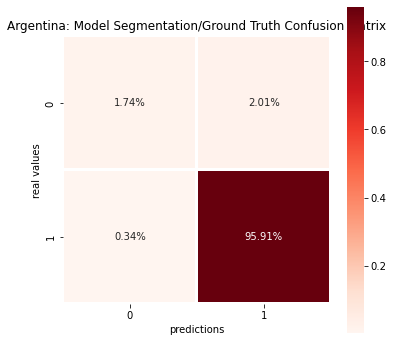

In [6]:
import seaborn as sns
import os
import numpy as np
import sys
import numpy as np
import skimage.color
import skimage.io
from matplotlib import pyplot as plt
from imageio import imread

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/RESULTS/Fullset/Predicted_masks/Tiles_stitched') 
# SI pic
Y_pred = imread('France_predicted.png') #Argentina_predicted.png

Y_pred = Y_pred/255

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/RESULTS/Fullset/Predicted_masks/Tiles_stitched/Ground_truth')
# ground truth
Y_val = imread('France_Ground_truth_stitched.png') #/ 255) #Argentina_Ground_truth_stitched.png

Y_val = Y_val/255
#print("unique", np.unique(y_true))


FP = len(np.where(Y_pred - Y_val  == -1)[0])
FN = len(np.where(Y_pred - Y_val  == 1)[0])
TP = len(np.where(Y_pred + Y_val ==2)[0])
TN = len(np.where(Y_pred + Y_val == 0)[0])
cmat = [[TP, FN], [FP, TN]]
precision_score = TP / (FP + TP)
print('precision:',precision_score)


recall_score = TP / (FN + TP)
print("recall", recall_score) 


F1_score = 2* precision_score * recall_score/ (precision_score + recall_score)
print("F1_score", F1_score)



plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.title("Argentina: Model Segmentation/Ground Truth Confusion Matrix")
plt.xlabel("predictions")
plt.ylabel("real values")
#plt.show()

In [210]:
# bar chart of miou and F1 score 

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/RESULTS/Fullset/Predicted_masks/Tiles_stitched') 
# SI pic
Y_pred = imread('Argentina_predicted.png')

Y_pred = Y_pred/255

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/RESULTS/Fullset/Predicted_masks/Tiles_stitched/Ground_truth')
# ground truth
Y_val = imread('Argentina_Ground_truth_stitched.png') #/ 255) 

Y_val = Y_val/255

from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice


dice_coef(Y_val, Y_pred)

Using TensorFlow backend.
/Users/emilybirch/opt/anaconda3/envs/Dissertation_ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/emilybirch/opt/anaconda3/envs/Dissertation_ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/emilybirch/opt/anaconda3/envs/Dissertation_ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np

ValueError: Invalid reduction dimension 2 for input with 2 dimensions. for 'Sum' (op: 'Sum') with input shapes: [1952,1952], [3] and with computed input tensors: input[1] = <1 2 3>.

In [ ]:
# PLOT F1 SCORES

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

data = [[0.8092, 0.7780, 0.7664], # first ones will be model f1score
        [0.7755, 0.8403, 0.8829]] # second will be SI f1

#X = np.arange(3)
x = np.arange(len(labels))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1.2]) 
first_bar = ax.bar(x + 0.00, data[0], color = 'b', alpha = 0.5, width = 0.12)
sec_bar = ax.bar(x + 0.12, data[1], color = 'g', alpha = 0.5, width = 0.12)


#cant use bar label because i dont have the newest matplotlib
#ax.bar_label(first_bar, padding=3)
#ax.bar_label(sec_bar, padding=3)

#plt.xlim([, 40])
#plt.ylim([-40, 40])

labels = ['Alaska','Argentina', 'Norway']

ax.set_ylabel('F1 Segmentation Score', fontsize=14)
ax.set_xlabel('Test Site', fontsize=14)
ax.set_title('Comparison of SI and Model F1 Scores at Non-Forested test sites', fontsize=14, pad=20)
ax.set_xticks(x)
plt.xticks(rotation=35)

#tick_spacing = 1
#ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.legend()
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')

y_ticks = np.arange(0.70,1.0,0.02)
plt.yticks(y_ticks)

#ax.set_ylim([0.50, 0.8])
plt.ylim([0.70, 0.9])

# np arrange i sstart, stop, step



orange_patch = mpatches.Patch(color='b', alpha = 0.5, label='Model F1 Score')
blue_patch = mpatches.Patch(color='g', alpha = 0.5, label='SI F1 Score')
ax.legend(handles=[orange_patch, blue_patch],  frameon=False, fontsize=12, bbox_to_anchor=(.99, .99))


In [ ]:
# plot miou

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

data = [[0.7933, 0.8140, 0.7887], # first ones will be model miou score
        [0.7412, 0.8389, 0.8685]] # second will be SI miou

#X = np.arange(3)
x = np.arange(len(labels))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1.2]) 
first_bar = ax.bar(x + 0.00, data[0], color = 'b', alpha = 0.5, width = 0.12)
sec_bar = ax.bar(x + 0.12, data[1], color = 'g', alpha = 0.5, width = 0.12)


#cant use bar label because i dont have the newest matplotlib
#ax.bar_label(first_bar, padding=3)
#ax.bar_label(sec_bar, padding=3)

#plt.xlim([, 40])
#plt.ylim([-40, 40])

labels = ['Alaska','Argentina', 'Norway']

ax.set_ylabel('mIoU Segmentation Score', fontsize=14)
ax.set_xlabel('Test Site', fontsize=14)
ax.set_title('Comparison of SI and Model mIoU Scores at Non-Forested test sites', fontsize=14, pad=20)
ax.set_xticks(x)
plt.xticks(rotation=35)

#tick_spacing = 1
#ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.legend()
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')

y_ticks = np.arange(0.70,1.0,0.02)
plt.yticks(y_ticks)

#ax.set_ylim([0.50, 0.8])
plt.ylim([0.70, 0.9])

# np arrange i sstart, stop, step



orange_patch = mpatches.Patch(color='b', alpha = 0.5, label='Model mIoU')
blue_patch = mpatches.Patch(color='g', alpha = 0.5, label='SI mIoU')
ax.legend(handles=[orange_patch, blue_patch],  frameon=False, fontsize=12, bbox_to_anchor=(.99, .99))


In [ ]:
# for forested sites


# FOR FORESTED SITES NOW!!

# F1 score


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

data = [[0.7179, 0.7207, 0.8524], # first ones will be model miou score
        [0.744, 0.74, 0.90]] # second will be SI miou

#X = np.arange(3)
x = np.arange(len(labels))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1.2]) 
first_bar = ax.bar(x + 0.00, data[0], color = 'b', alpha = 0.5, width = 0.12)
sec_bar = ax.bar(x + 0.12, data[1], color = 'g', alpha = 0.5, width = 0.12)


#cant use bar label because i dont have the newest matplotlib
#ax.bar_label(first_bar, padding=3)
#ax.bar_label(sec_bar, padding=3)

#plt.xlim([, 40])
#plt.ylim([-40, 40])

labels = ['Canada','France', 'New Zealand']

ax.set_ylabel('F1 Segmentation Score', fontsize=14)
ax.set_xlabel('Test Site', fontsize=14)
ax.set_title('Comparison of SI and Model F1 Scores at Forested test sites', fontsize=14, pad=20)
ax.set_xticks(x)
plt.xticks(rotation=35)

#tick_spacing = 1
#ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.legend()
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')

y_ticks = np.arange(0.40,1.0,0.04)
plt.yticks(y_ticks)

#ax.set_ylim([0.50, 0.8])
plt.ylim([0.40, 0.96])

# np arrange i sstart, stop, step



orange_patch = mpatches.Patch(color='b', alpha = 0.5, label='Model F1 Score')
blue_patch = mpatches.Patch(color='g', alpha = 0.5, label='SI F1 Score')
ax.legend(handles=[orange_patch, blue_patch],  frameon=False, fontsize=12, bbox_to_anchor=(.99, .99))


In [ ]:
# FOR FORESTED SITES NOW!!




import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

data = [[0.7179, 0.7207, 0.8524], # first ones will be model miou score
        [0.5661, 0.6721, 0.9245]] # second will be SI miou

#X = np.arange(3)
x = np.arange(len(labels))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1.2]) 
first_bar = ax.bar(x + 0.00, data[0], color = 'b', alpha = 0.5, width = 0.12)
sec_bar = ax.bar(x + 0.12, data[1], color = 'g', alpha = 0.5, width = 0.12)


#cant use bar label because i dont have the newest matplotlib
#ax.bar_label(first_bar, padding=3)
#ax.bar_label(sec_bar, padding=3)

#plt.xlim([, 40])
#plt.ylim([-40, 40])

labels = ['Canada','France', 'New Zealand']

ax.set_ylabel('mIoU Segmentation Score', fontsize=14)
ax.set_xlabel('Test Site', fontsize=14)
ax.set_title('Comparison of SI and Model mIoU Scores at Forested test sites', fontsize=14, pad=20)
ax.set_xticks(x)
plt.xticks(rotation=35)

#tick_spacing = 1
#ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.legend()
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')

y_ticks = np.arange(0.40,1.0,0.04)
plt.yticks(y_ticks)

#ax.set_ylim([0.50, 0.8])
plt.ylim([0.40, 0.96])

# np arrange i sstart, stop, step



orange_patch = mpatches.Patch(color='b', alpha = 0.5, label='Model mIoU')
blue_patch = mpatches.Patch(color='g', alpha = 0.5, label='SI mIoU')
ax.legend(handles=[orange_patch, blue_patch],  frameon=False, fontsize=12, bbox_to_anchor=(.99, .99))
